In [1]:
import yfinance as yf
import pandas as pd
import os

In [2]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [4]:
sp500.index = pd.to_datetime(sp500.index, utc=True).tz_localize(None)

In [5]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 05:00:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 05:00:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 05:00:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 05:00:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 05:00:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2026-01-21 05:00:00,6810.709961,6910.390137,6804.959961,6875.620117,5835520000,0.0,0.0
2026-01-22 05:00:00,6914.439941,6934.750000,6893.620117,6913.350098,5307580000,0.0,0.0
2026-01-23 05:00:00,6907.850098,6932.959961,6895.500000,6915.609863,4871930000,0.0,0.0


<Axes: xlabel='Date'>

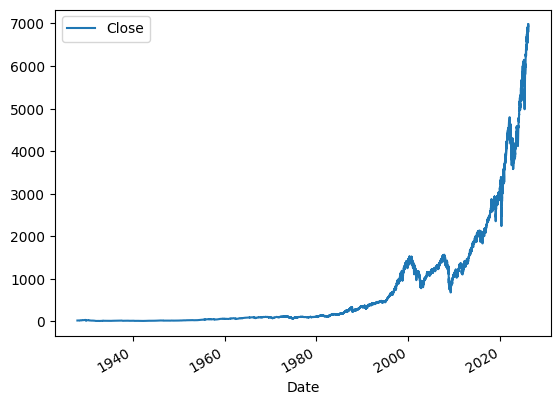

In [6]:
sp500.plot.line(y="Close", use_index=True)

In [7]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [8]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [9]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [10]:
sp500 = sp500.loc["1990-01-01":].copy()

In [11]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",100
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metr

In [13]:
print("Predictions distribution:")
print(preds.value_counts())

print("\nActual target distribution:")
print(test["Target"].value_counts())

print("\nPrediction probabilities (first 10):")
preds_proba = model.predict_proba(test[predictors])
print(preds_proba[:10])

Predictions distribution:
0    100
Name: count, dtype: int64

Actual target distribution:
Target
1    61
0    39
Name: count, dtype: int64

Prediction probabilities (first 10):
[[0.60397733 0.39602267]
 [0.67366247 0.32633753]
 [0.63678009 0.36321991]
 [0.67025528 0.32974472]
 [0.63998483 0.36001517]
 [0.63998483 0.36001517]
 [0.67356411 0.32643589]
 [0.66366247 0.33633753]
 [0.63998483 0.36001517]
 [0.63192212 0.36807788]]


In [14]:
# Add rolling average ratios
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_avg = sp500.rolling(horizon).mean()
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_avg["Close"]
    new_predictors.append(ratio_column)

sp500 = sp500.dropna()
sp500 = sp500.loc["1990-01-01":].copy()

# Retrain
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)
predictors_all = ["Close", "Volume", "Open", "High", "Low"] + new_predictors
model.fit(train[predictors_all], train["Target"])

preds_proba = model.predict_proba(test[predictors_all])[:, 1]
preds = (preds_proba >= 0.4).astype(int)
preds = pd.Series(preds, index=test.index)

print(f"Precision: {precision_score(test['Target'], preds)}")
print(f"Predictions: {pd.Series(preds).value_counts()}")

Precision: 0.6458333333333334
Predictions: 0    52
1    48
Name: count, dtype: int64


<Axes: xlabel='Date'>

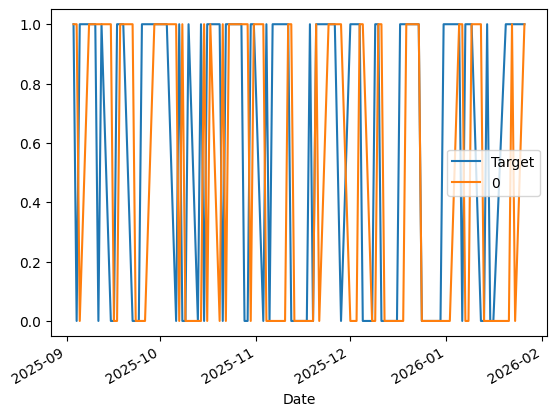

In [15]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [16]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [17]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [18]:
predictions = backtest(sp500, model, predictors)

In [19]:
predictions["Predictions"].value_counts()

Predictions
0    3622
1    1962
Name: count, dtype: int64

In [20]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5458715596330275

In [21]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.547278
0    0.452722
Name: count, dtype: float64

In [22]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [23]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [24]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Close_Ratio_5,Close_Ratio_60,Close_Ratio_250,Close_Ratio_1000,Trend_2,Trend_5,Trend_60,Trend_250,Trend_1000
Date,,,,,,,,,,,,,,,,,
1997-11-25 05:00:00,946.669983,954.469971,944.710022,950.820007,587890000,951.640015,1,1.002187,0.997890,1.008665,1.113339,1.516920,1.0,4.0,33.0,137.0,562.0
1997-11-26 05:00:00,950.820007,956.469971,950.820007,951.640015,487750000,955.400024,1,1.000431,0.997275,1.009111,1.113282,1.517046,2.0,4.0,33.0,138.0,563.0
1997-11-28 05:00:00,951.640015,959.130005,951.640015,955.400024,189070000,974.770020,1,1.001972,1.001967,1.012659,1.116599,1.521842,2.0,4.0,33.0,139.0,564.0
1997-12-01 05:00:00,955.400024,974.770020,955.400024,974.770020,590300000,971.679993,0,1.010035,1.019783,1.032356,1.138015,1.551433,2.0,4.0,34.0,140.0,564.0
1997-12-02 05:00:00,974.780029,976.200012,969.830017,971.679993,576120000,976.770020,1,0.998412,1.011259,1.028349,1.133204,1.545272,1.0,4.0,33.0,140.0,563.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-20 05:00:00,6865.240234,6871.169922,6789.049805,6796.859863,5769500000,6875.620117,1,0.989579,0.983010,0.995256,1.084910,1.349826,0.0,1.0,35.0,143.0,534.0
2026-01-21 05:00:00,6810.709961,6910.390137,6804.959961,6875.620117,5835520000,6913.350098,1,1.005760,0.996942,1.006451,1.096929,1.364785,1.0,2.0,35.0,143.0,535.0
2026-01-22 05:00:00,6914.439941,6934.750000,6893.620117,6913.350098,5307580000,6915.609863,1,1.002736,1.002798,1.011674,1.102389,1.371577,2.0,3.0,35.0,143.0,536.0


In [25]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [26]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [27]:
predictions = backtest(sp500, model, new_predictors)

In [28]:
predictions["Predictions"].value_counts()

Predictions
0.0    3998
1.0     586
Name: count, dtype: int64

In [29]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5409556313993175

In [30]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.544939
0    0.455061
Name: count, dtype: float64

In [31]:
predictions

,Target,Predictions
Date,,
2007-11-05 05:00:00,1,1.0
2007-11-06 05:00:00,0,1.0
2007-11-07 05:00:00,0,1.0
2007-11-08 05:00:00,0,1.0
2007-11-09 05:00:00,0,1.0
...,...,...
2026-01-20 05:00:00,1,0.0
2026-01-21 05:00:00,1,0.0
2026-01-22 05:00:00,1,0.0
